In [184]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA, DictionaryLearning, IncrementalPCA, KernelPCA
from matplotlib import cm
from sklearn.metrics import rand_score, silhouette_score, fowlkes_mallows_score, calinski_harabasz_score, \
    homogeneity_score, mutual_info_score, davies_bouldin_score, v_measure_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, FunctionTransformer, minmax_scale
from concurrent.futures import ThreadPoolExecutor
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.feature_selection import f_classif,mutual_info_classif,chi2
import yellowbrick.features.pca

from sklearn.preprocessing import LabelEncoder
import yellowbrick.cluster

In [185]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [186]:
save_prefix="analysis/images/"

In [187]:
df1 = pd.read_csv("data/Dataset_Handwritten_English/flattened_images_30x40.csv",low_memory=False)

y = df1['label'].astype(str)
X = df1.drop(['label'],axis=1)
_y_unique_labels = y.unique().shape[0]
y=LabelEncoder().fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y)

In [188]:
internal_scoring_algos = {
    "si":silhouette_score,  #  measure of how tight clusters are, and how spread out they are. -1 to 1 (best)
    "ch":calinski_harabasz_score,  #  Ratio of cluster tightness to cluster dispersion.  higher ratio is tighter, more dispersed clusters
    "db":davies_bouldin_score  # Determines how similar a cluster is to its closest cluster neighbors
}
external_scoring_algos = {
    "fm":fowlkes_mallows_score,
    "hs":homogeneity_score,  # measure of how consistently samples of a given ground truth are placed into the correct cluster
    "mi":mutual_info_score,  # Determines the similarity between clusters by examining samples within different clusters and their similarity
    "rs":rand_score,  #  Measures similarity between two clusterings by considering all pairs and determining what has been assigned to same, or different, clusters
    "vs":v_measure_score, #  Measures cluster labeling to truthful labeling, irregardless of permutations of labels
}
all_scores={}

## Visualize KMeans

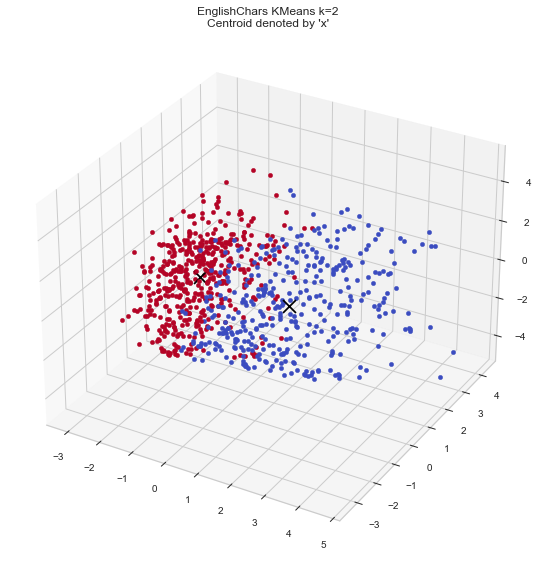

{
    "internal_scores": {
        "si": 0.07492813225829452,
        "ch": 59.04914076319133,
        "db": 3.736476126051544
    },
    "external_scores": {
        "fm": 0.10472492357537909,
        "hs": 0.032842413937794614,
        "mi": 0.13464464862070324,
        "rs": 0.49802409612029347,
        "vs": 0.05624944538306531
    }
}


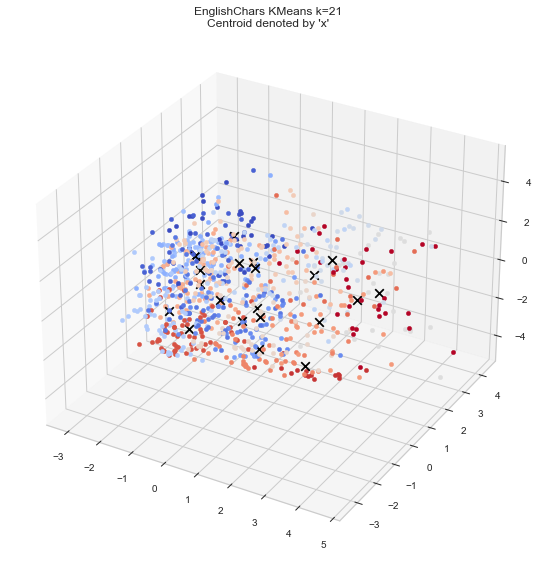

{
    "internal_scores": {
        "si": 0.01639285124959587,
        "ch": 16.413536740123508,
        "db": 2.979436852615758
    },
    "external_scores": {
        "fm": 0.08234886591682966,
        "hs": 0.2950259987365058,
        "mi": 1.209523514595722,
        "rs": 0.9356042468173638,
        "vs": 0.3422208855469037
    }
}


In [189]:
optimals=(2,21) # from EnglishCharactersAnalysis.ipynb..

for k in optimals:
    title=f"EnglishChars KMeans k={k}\nCentroid denoted by 'x'"
    model = KMeans(n_clusters=k,n_init=3,copy_x=True,algorithm='auto').fit(X_train)
    pred=model.predict(X_test)
    color_map = cm.get_cmap('coolwarm', k)
    pca = PCA(3).fit(X_test)
    x_points = pca.transform(X_test)
    centroids = pca.transform(model.cluster_centers_)
    fig = plt.figure(figsize=(12.8,9.6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    for (x, y, z), label in zip(x_points, pred):
        color = color_map(label)
        ax.scatter(x,y,z,color=color,alpha=1.0)
    for i in range(len(centroids)):
        color='black'
        x,y,z=centroids[i]
        marker = 'x'
        ax.scatter(x,y,z,
                   color=color,
                   marker=marker,
                   alpha=1.0,
                   s=170-(len(centroids)**1.5))
    title=title.replace(' ','_').replace('\n','_')
    savepath=f"{save_prefix}{title}.png"
    plt.savefig(savepath)
    plt.show()
    internal_scores = {name:f(X_test,pred) for name,f in internal_scoring_algos.items()}
    external_scores = {name:f(y_test,pred) for name,f in external_scoring_algos.items()}
    scores={
        "internal_scores":internal_scores,
        "external_scores":external_scores
    }
    print(json.dumps(scores,indent=4))
    all_scores[title]=scores

## Visualize EMax

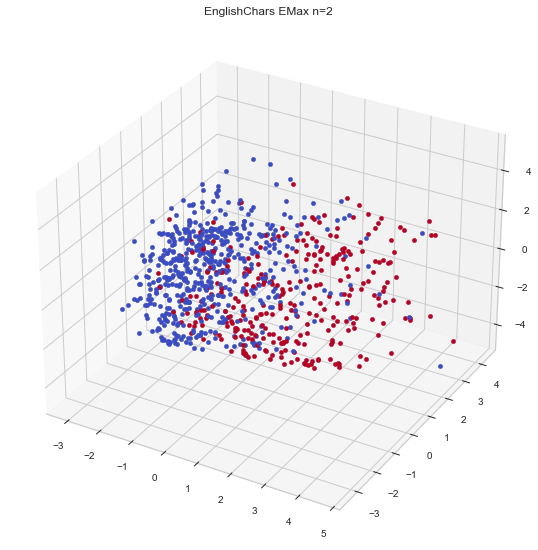

{
    "internal_scores": {
        "si": 0.06903135992465295,
        "ch": 36.7314747558516,
        "db": 4.6449393827933445
    },
    "external_scores": {
        "fm": 0.10024548170894777,
        "hs": 0.01991109415434754,
        "mi": 0.08162987900778794,
        "rs": 0.46266147097512783,
        "vs": 0.03435802925149671
    }
}


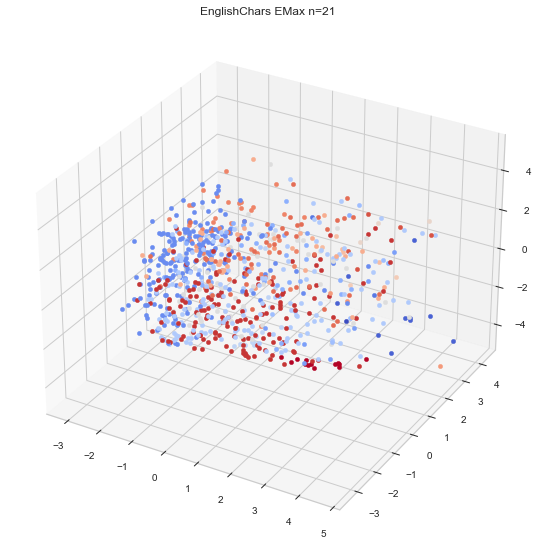

{
    "internal_scores": {
        "si": 0.007559160736360406,
        "ch": 8.868130874722334,
        "db": 3.2162466880174554
    },
    "external_scores": {
        "fm": 0.06417742648507586,
        "hs": 0.16084076554623,
        "mi": 0.6594018454878317,
        "rs": 0.8391289511197706,
        "vs": 0.20932719434745295
    }
}


In [190]:
optimals=(2,21) # from EnglishCharactersAnalysis.ipynb..
scores = {}
for k in optimals:
    title=f"EnglishChars EMax n={k}"
    model = GaussianMixture(n_components=k, covariance_type='full', max_iter=50, n_init=3,tol=1e-1).fit(X_train)
    pred=model.predict(X_test)
    color_map = cm.get_cmap('coolwarm', k)
    pca = PCA(3).fit(X_test)
    x_points = pca.transform(X_test)
    fig = plt.figure(figsize=(12.8,9.6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    for (x, y, z), label in zip(x_points, pred):
        color = color_map(label)
        ax.scatter(x,y,z,color=color,alpha=1.0)
    savepath=f"{save_prefix}{title.replace(' ','_')}.png"
    plt.savefig(savepath)
    plt.show()
    internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
    external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
    scores={
        "internal_scores":internal_scores,
        "external_scores":external_scores
    }
    print(json.dumps(scores,indent=4))
    all_scores[title]=scores

## Visualize PCA

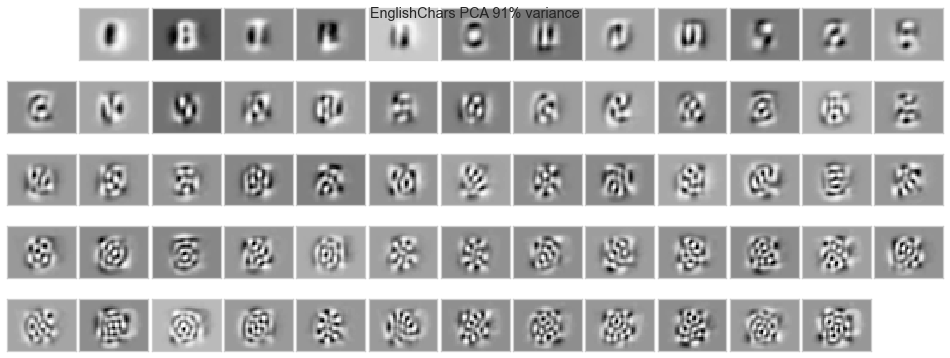

In [191]:
pca=PCA(0.91).fit(X_train)
pca_x = pca.transform(X_train)
ncomponents = len(pca.components_)

title=f"EnglishChars PCA 91% variance"
cols=5
rows=1+ncomponents//cols
fig = plt.figure(figsize=(rows,cols))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,ncomponents):
    ax = fig.add_subplot(cols, rows, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca.components_[i, :], (30, 40)), cmap=plt.cm.Greys, interpolation='nearest')
plt.suptitle(title)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

## Visualize Inverse PCA

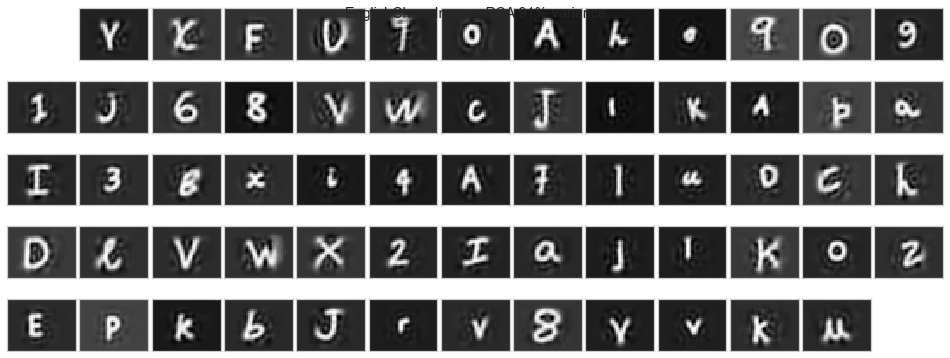

In [192]:
# Inverse transform to see how well this is applied to the model

pca_inv_x = pca.inverse_transform(pca_x)

title=f"EnglishChars Inverse PCA 91% variance"
cols=5
rows=1+ncomponents//cols
fig = plt.figure(figsize=(rows,cols))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,ncomponents):
    ax = fig.add_subplot(cols, rows, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pca_inv_x[i, :], (30, 40)), cmap=plt.cm.Greys, interpolation='nearest')
plt.suptitle(title)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

## Visualize ICA

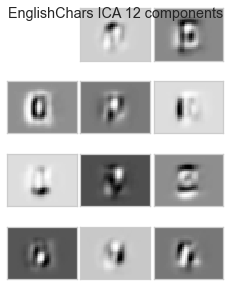

In [193]:
ica=FastICA(n_components=12, # I seemingly should choose no less than 62 components, because there are 62 classifications
            whiten=True,
            fun="cube").fit(X_train)  #Selected cube as it gave the best output based on the visualization
ica_x = ica.transform(X_train)
ncomponents = len(ica.components_)

title=f"EnglishChars ICA 12 components"
cols=5
rows=1+ncomponents//cols
fig = plt.figure(figsize=(rows,cols))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,ncomponents):
    ax = fig.add_subplot(cols, rows, i + 1, xticks=[], yticks=[])
    #ax.imshow(np.reshape(pca.components_[i, :], (900, 1200)), cmap=plt.cm.bone, interpolation='nearest')
    ax.imshow(np.reshape(ica.components_[i, :], (30, 40)), cmap=plt.cm.Greys, interpolation='nearest')
plt.suptitle(title)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

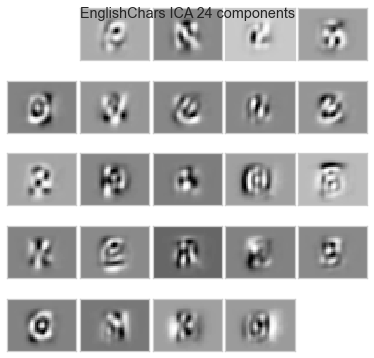

In [194]:
ica=FastICA(n_components=24, # I seemingly should choose no less than 62 components, because there are 62 classifications
            whiten=True,
            fun="cube").fit(X_train)  #Selected cube as it gave the best output based on the visualization
ica_x = ica.transform(X_train)
ncomponents = len(ica.components_)

title=f"EnglishChars ICA 24 components"
cols=5
rows=1+ncomponents//cols
fig = plt.figure(figsize=(rows,cols))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,ncomponents):
    ax = fig.add_subplot(cols, rows, i + 1, xticks=[], yticks=[])
    #ax.imshow(np.reshape(pca.components_[i, :], (900, 1200)), cmap=plt.cm.bone, interpolation='nearest')
    ax.imshow(np.reshape(ica.components_[i, :], (30, 40)), cmap=plt.cm.Greys, interpolation='nearest')
plt.suptitle(title)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

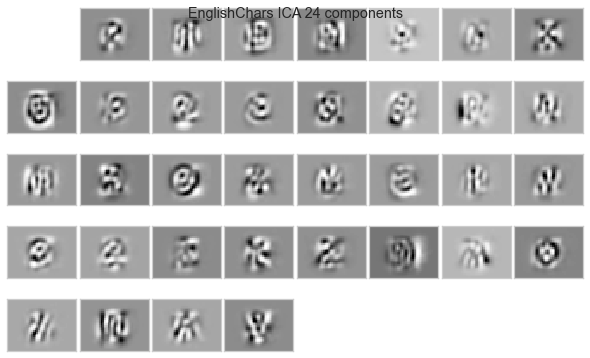

In [195]:
ica=FastICA(n_components=36, # I seemingly should choose no less than 62 components, because there are 62 classifications
            whiten=True,
            fun="cube").fit(X_train)  #Selected cube as it gave the best output based on the visualization
ica_x = ica.transform(X_train)
ncomponents = len(ica.components_)

title=f"EnglishChars ICA 24 components"
cols=5
rows=1+ncomponents//cols
fig = plt.figure(figsize=(rows,cols))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,ncomponents):
    ax = fig.add_subplot(cols, rows, i + 1, xticks=[], yticks=[])
    #ax.imshow(np.reshape(pca.components_[i, :], (900, 1200)), cmap=plt.cm.bone, interpolation='nearest')
    ax.imshow(np.reshape(ica.components_[i, :], (30, 40)), cmap=plt.cm.Greys, interpolation='nearest')
plt.suptitle(title)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

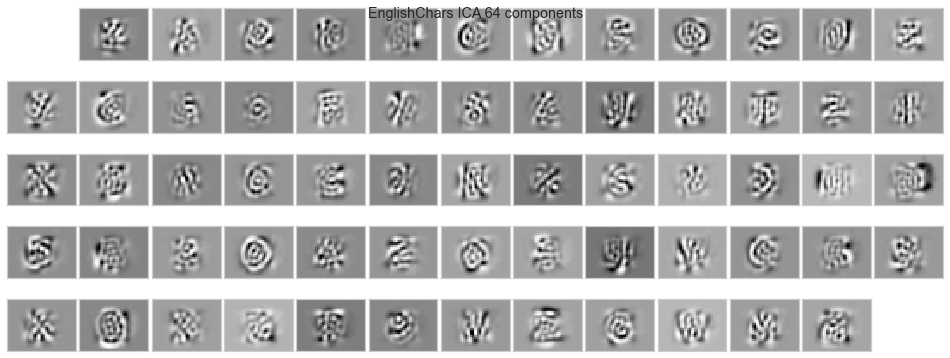

In [196]:
ica=FastICA(n_components=64, # I seemingly should choose no less than 62 components, because there are 62 classifications
            whiten=True,
            fun="cube").fit(X_train)  #Selected cube as it gave the best output based on the visualization
ica_x = ica.transform(X_train)
ncomponents = len(ica.components_)

title=f"EnglishChars ICA 64 components"
cols=5
rows=1+ncomponents//cols
fig = plt.figure(figsize=(rows,cols))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(1,ncomponents):
    ax = fig.add_subplot(cols, rows, i + 1, xticks=[], yticks=[])
    #ax.imshow(np.reshape(pca.components_[i, :], (900, 1200)), cmap=plt.cm.bone, interpolation='nearest')
    ax.imshow(np.reshape(ica.components_[i, :], (30, 40)), cmap=plt.cm.Greys, interpolation='nearest')
plt.suptitle(title)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

## Visualize R-Proj

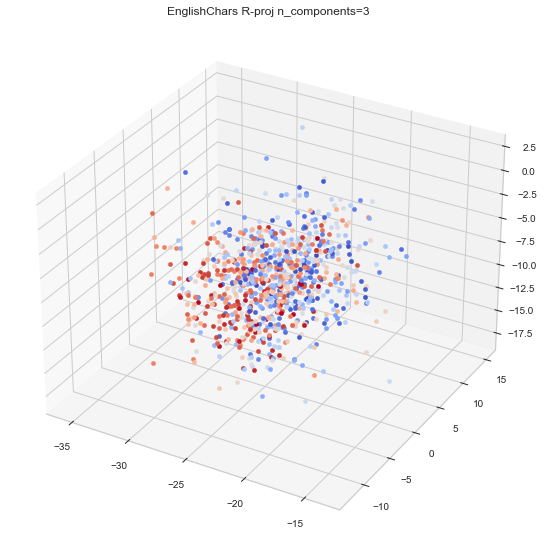

{
    "internal_scores": {
        "si": 0.007559160736360406,
        "ch": 8.868130874722334,
        "db": 3.2162466880174554
    },
    "external_scores": {
        "fm": 0.06417742648507586,
        "hs": 0.16084076554623,
        "mi": 0.6594018454878317,
        "rs": 0.8391289511197706,
        "vs": 0.20932719434745295
    }
}


In [197]:
model=SparseRandomProjection(n_components=3,
                             density='auto',
                             dense_output=True).fit(X_train)

title=f"EnglishChars R-proj n_components=3"
x,z,y=np.split(model.transform(X_test),3,axis=1)
color_map = cm.get_cmap('coolwarm',_y_unique_labels)
fig = plt.figure(figsize=(12.8,9.6))
ax = fig.add_subplot(projection='3d')
ax.set_title(title)
for x, y, z,label in zip(x,y,z,y_test):
    color = color_map(label)
    ax.scatter(x,y,z,color=color,alpha=1.0)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))

## Visualize KPCA

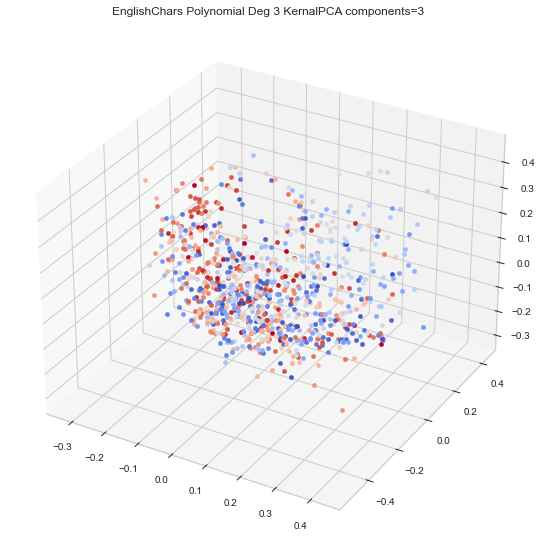

In [198]:
kpca=KernelPCA(3,kernel='poly',degree=3).fit(X_train)
pca_x = kpca.transform(X_train)
title=f"EnglishChars Polynomial Deg 3 KernalPCA components=3"
x,z,y=np.split(kpca.transform(X_test),3,axis=1)
color_map = cm.get_cmap('coolwarm',_y_unique_labels)
fig = plt.figure(figsize=(12.8,9.6))
ax = fig.add_subplot(projection='3d')
ax.set_title(title)
for x, y, z,label in zip(x,y,z,y_test):
    color = color_map(label)
    ax.scatter(x,y,z,color=color,alpha=1.0)
savepath=f"{save_prefix}{title.replace(' ','_')}.png"
plt.savefig(savepath)
plt.show()

## PCA+KMeans

In [199]:
title=f"EnglishChars PCA 91% + KMeans"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",PCA(0.91)),
    ("cluster",KMeans(n_clusters=21,n_init=3,copy_x=True,algorithm='auto')) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": 0.0364589414423438,
        "ch": 17.539104166742025,
        "db": 3.1082560127793406
    },
    "external_scores": {
        "fm": 0.08027942872262751,
        "hs": 0.10474780670232921,
        "mi": 0.4294365101766796,
        "rs": 0.7362498555223487,
        "vs": 0.14995327039746056
    }
}


##  ICA+KMeans

In [200]:
title=f"EnglishChars ICA 800 + KMeans"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",FastICA(800)),
    ("cluster",KMeans(n_clusters=21,n_init=3,copy_x=True,algorithm='auto')) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.008893234604506164,
        "ch": 3.8647904058112665,
        "db": 6.3735588951368785
    },
    "external_scores": {
        "fm": 0.07504783113381824,
        "hs": 0.05650542780815022,
        "mi": 0.23165634191205225,
        "rs": 0.6774515793471262,
        "vs": 0.08500976477448603
    }
}


##  R-Proj+Kmeans

In [201]:
title=f"EnglishChars RProj 64 + KMeans"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",SparseRandomProjection(64)),
    ("cluster",KMeans(n_clusters=21,n_init=3,copy_x=True,algorithm='auto')) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": 0.0215171732070496,
        "ch": 16.854135907352017,
        "db": 3.3090636229670367
    },
    "external_scores": {
        "fm": 0.0762369796588009,
        "hs": 0.10929972379730601,
        "mi": 0.4480980884323028,
        "rs": 0.7888699921294079,
        "vs": 0.1526049881444678
    }
}


## Visualize KPCA+KMeans

In [202]:
title=f"EnglishChars KernelPCA 64 + KMeans"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",KernelPCA(64,kernel='linear')),
    ("cluster",KMeans(n_clusters=21,n_init=3,copy_x=True,algorithm='auto')) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": 0.04117631227568882,
        "ch": 18.900950440579425,
        "db": 3.2376680154658937
    },
    "external_scores": {
        "fm": 0.0814735821446267,
        "hs": 0.10268863444238176,
        "mi": 0.420994483780104,
        "rs": 0.7227982981908646,
        "vs": 0.14825122634609006
    }
}


##  PCA+EMax

In [203]:
title=f"EnglishChars PCA 91% + EMax"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",PCA(0.91)),
    ("cluster", GaussianMixture(n_components=21, covariance_type='full', max_iter=50, n_init=3,tol=1e-1)) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": 0.0018261167642432212,
        "ch": 20.571286483781947,
        "db": 5.170596196653266
    },
    "external_scores": {
        "fm": 0.07886037042479865,
        "hs": 0.054577313997937756,
        "mi": 0.2237516182529297,
        "rs": 0.7114629944575621,
        "vs": 0.08256033951840182
    }
}


## Visualize ICA+EMax

In [204]:
title=f"EnglishChars ICA 800 + EMax"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",FastICA(800)),
    ("cluster", GaussianMixture(n_components=21, covariance_type='full', max_iter=50, n_init=3,tol=1e-1)) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.06720588867031596,
        "ch": 4.934422354529166,
        "db": 3.3314391681986764
    },
    "external_scores": {
        "fm": 0.10850234001145698,
        "hs": 0.025009933204205508,
        "mi": 0.10253368326352798,
        "rs": 0.2651949209913644,
        "vs": 0.04429395832350896
    }
}


## Visualize R-Proj+EMax

In [205]:
title=f"EnglishChars RProj 64 + EMax"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",SparseRandomProjection(64)),
    ("cluster", GaussianMixture(n_components=21, covariance_type='full', max_iter=50, n_init=3,tol=1e-1)) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": -0.0018751836795278113,
        "ch": 14.920500684298338,
        "db": 5.27077117793494
    },
    "external_scores": {
        "fm": 0.07567751203991903,
        "hs": 0.08211174389697054,
        "mi": 0.3366350270592559,
        "rs": 0.7622806003665604,
        "vs": 0.11797874321786987
    }
}


## Visualize KPCA+EMax

In [206]:
title=f"EnglishChars linear KPCA 64 + EMax"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",KernelPCA(64,kernel='linear')),
    ("cluster", GaussianMixture(n_components=21, covariance_type='full', max_iter=50, n_init=3,tol=1e-1)) # for graphing
]).fit(X_train)

pred=pipeline.predict(X_test)

internal_scores = {name:float(f(X_test,pred)) for name,f in internal_scoring_algos.items()}
external_scores = {name:float(f(y_test,pred)) for name,f in external_scoring_algos.items()}
scores={
    "internal_scores":internal_scores,
    "external_scores":external_scores
}
print(json.dumps(scores,indent=4))
all_scores[title]=scores

{
    "internal_scores": {
        "si": 0.0004362335509273463,
        "ch": 14.773574337599666,
        "db": 4.46177385651788
    },
    "external_scores": {
        "fm": 0.07593269677346218,
        "hs": 0.06546483182754777,
        "mi": 0.2683873753959968,
        "rs": 0.7304900131543461,
        "vs": 0.09671551781291417
    }
}


## Train PCA+NN

In [207]:
title=f"EnglishChars Train NN with PCA 91%"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",PCA(0.91,whiten=False)),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=scores

0.5052754982415005


## Train ICA+NN

In [208]:
title=f"EnglishChars Train NN with ICA 800"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",FastICA(800)),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=scores

0.13599062133645956


## Train R-Proj+NN

In [209]:
title=f"EnglishChars Train NN with RProj 64"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",SparseRandomProjection(64)),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score

0.41735052754982416


## Train KPCA+NN

In [210]:
title=f"EnglishChars Train NN with linear KPCA 64"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("fr",KernelPCA(64,kernel='linear')),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score

0.5029308323563892


## Train KMeans+NN

In [211]:
title=f"EnglishChars Train NN with KMeans 21"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("cluster",KMeans(n_clusters=21,n_init=3,copy_x=True,algorithm='auto')),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=100)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score


0.03399765533411489


## Train EMax+NN

In [212]:
class GMMWrapper(GaussianMixture):
    def __init__(self,n_components=1, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10):
        super().__init__(n_components=n_components, covariance_type=covariance_type, tol=tol, reg_covar=reg_covar, max_iter=max_iter, n_init=n_init, init_params=init_params, weights_init=weights_init, means_init=means_init, precisions_init=precisions_init, random_state=random_state, warm_start=warm_start, verbose=verbose, verbose_interval=verbose_interval)
    def transform(self,*args,**kwargs):
        """
            So... what i want is a representation of how likely a given sample is going to be so come from any specifc n_cluster gaussians
            there is not transform method for this, because its not really a model.
            So what im doing instead, is getting the output of get_proba, which outputs basically what we would expect for a transform..
            for each sample it gives you an array of n_cluster length where each element in the array is the liklihood that the sample is part of that gaussian
        """
        return self.predict_proba(*args,**kwargs)

In [213]:
title=f"EnglishChars Train NN with EMax 24"
pipeline = Pipeline([
    ("scaler",StandardScaler()),
    ("cluster",GMMWrapper(24,covariance_type='full', max_iter=1, n_init=3,tol=1e-1)),
    ("model", MLPClassifier(hidden_layer_sizes=(1000,),max_iter=1500)) # for graphing
]).fit(X_train,y_train)

score = pipeline.score(X_test,y_test)
print(json.dumps(score,indent=4))
all_scores[title]=score

0.017584994138335287


In [214]:
print(json.dumps(all_scores,indent=4))

{
    "EnglishChars_KMeans_k=2_Centroid_denoted_by_'x'": {
        "internal_scores": {
            "si": 0.07492813225829452,
            "ch": 59.04914076319133,
            "db": 3.736476126051544
        },
        "external_scores": {
            "fm": 0.10472492357537909,
            "hs": 0.032842413937794614,
            "mi": 0.13464464862070324,
            "rs": 0.49802409612029347,
            "vs": 0.05624944538306531
        }
    },
    "EnglishChars_KMeans_k=21_Centroid_denoted_by_'x'": {
        "internal_scores": {
            "si": 0.01639285124959587,
            "ch": 16.413536740123508,
            "db": 2.979436852615758
        },
        "external_scores": {
            "fm": 0.08234886591682966,
            "hs": 0.2950259987365058,
            "mi": 1.209523514595722,
            "rs": 0.9356042468173638,
            "vs": 0.3422208855469037
        }
    },
    "EnglishChars EMax n=2": {
        "internal_scores": {
            "si": 0.06903135992465295,
   

In [215]:
import json
json.dump(all_scores,open("analysis/HandWrittenCharacters-scores.json","w"),indent=4)